In [1]:
# ==============================================================
#                   Entire File Made by Oscar Boman
# ==============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
from bioNet import BioNet, BioNetLoss
from torchvision.datasets import LFWPairs


import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Example

In [2]:


transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="../Pre-processing/Curated_Dataset", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(dataset.classes)

C:\Users\46737\AppData\Local\Temp\ipykernel_33412\1661205742.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  plt.imshow(dataset[0][0].T)


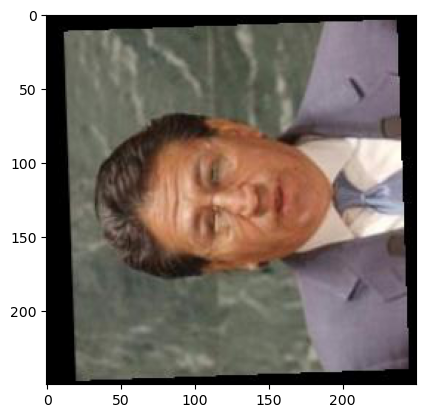

In [3]:
plt.imshow(dataset[0][0].T)

In [4]:

vgg16 = models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001) 


c:\Users\46737\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\46737\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/100], Loss: 2.6838
Validation Loss: 2.5806, Accuracy: 0.2761
Epoch [2/100], Loss: 2.1464
Validation Loss: 2.2126, Accuracy: 0.3836
Epoch [3/100], Loss: 1.6356
Validation Loss: 1.8811, Accuracy: 0.4433
Epoch [4/100], Loss: 1.1729
Validation Loss: 1.6748, Accuracy: 0.5194
Epoch [5/100], Loss: 0.7768
Validation Loss: 1.5559, Accuracy: 0.5597
Epoch [6/100], Loss: 0.4793
Validation Loss: 1.5300, Accuracy: 0.5896
Epoch [7/100], Loss: 0.2960
Validation Loss: 1.6285, Accuracy: 0.5955
Epoch [8/100], Loss: 0.1812
Validation Loss: 1.7625, Accuracy: 0.6000
Epoch [9/100], Loss: 0.1526
Validation Loss: 1.8151, Accuracy: 0.6000
Epoch [10/100], Loss: 0.1491
Validation Loss: 1.6508, Accuracy: 0.6239
Epoch [11/100], Loss: 0.1154
Validation Loss: 1.6113, Accuracy: 0.6060
Epoch [12/100], Loss: 0.0706
Validation Loss: 1.9611, Accuracy: 0.6030
Epoch [13/100], Loss: 0.0919
Validation Loss: 1.9467, Accuracy: 0.6254
Epoch [14/100], Loss: 0.0750
Validation Loss: 1.7186, Accuracy: 0.6313
Epoch [15/100],

<function matplotlib.pyplot.show(close=None, block=None)>

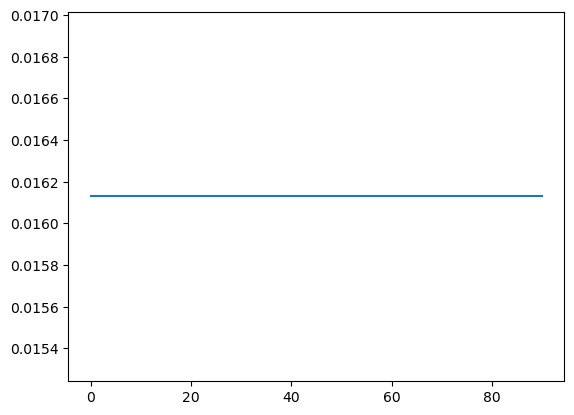

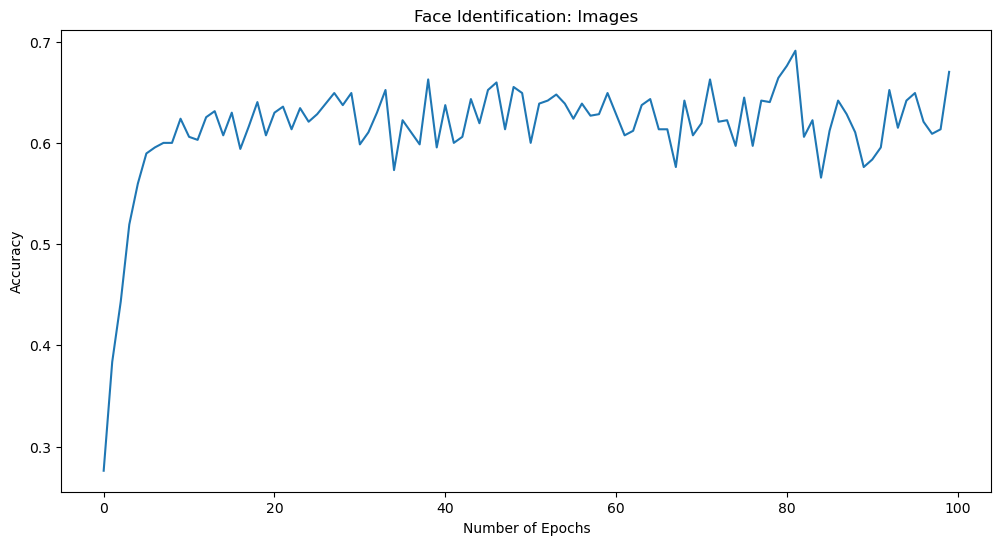

In [6]:
num_epochs = 100
val_accuracy_list = []
for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = vgg16(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        
        loss.backward()  # Backward pass (calculate gradients)
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Validate the model
    vgg16.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    
    val_loss /= len(val_loader.dataset)
    accuracy = correct / total
    val_accuracy_list.append(accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")




<function matplotlib.pyplot.show(close=None, block=None)>

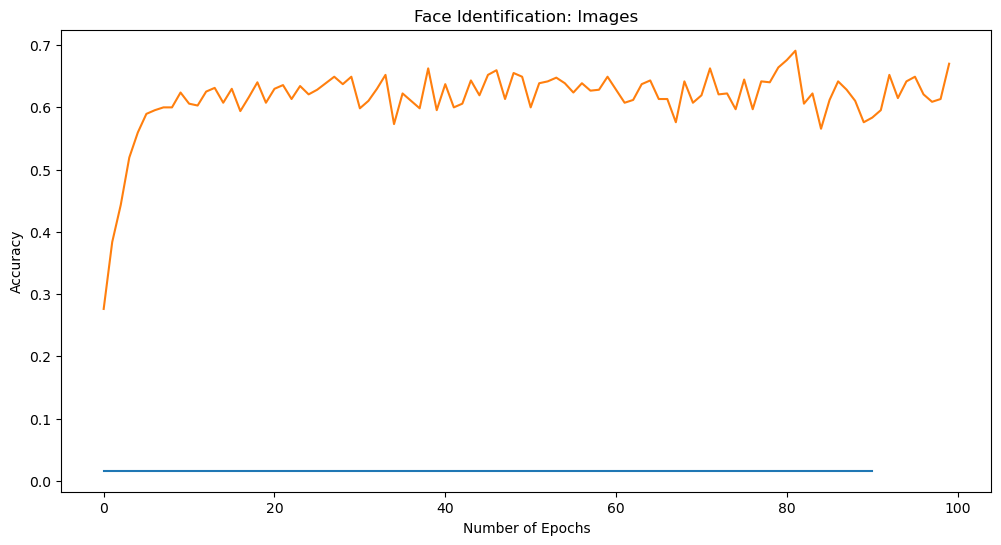

In [7]:

plt.figure(figsize=(12, 6))
plt.plot(np.arange(num_epochs, step=10), np.zeros(int(num_epochs/10)) + 1/num_classes, label='Naive Classifier')
plt.plot(np.arange(num_epochs), val_accuracy_list, label='Neural Network')
plt.title('Face Identification: Images')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show

#### MetricNet 

Epoch [10/500], Loss: 4.0773, Val Accuracy: 2.26%
Epoch [20/500], Loss: 3.9526, Val Accuracy: 3.30%
Epoch [30/500], Loss: 3.8689, Val Accuracy: 2.95%
Epoch [40/500], Loss: 3.8213, Val Accuracy: 3.30%
Epoch [50/500], Loss: 3.7793, Val Accuracy: 3.47%
Epoch [60/500], Loss: 3.7496, Val Accuracy: 3.65%
Epoch [70/500], Loss: 3.7056, Val Accuracy: 4.17%
Epoch [80/500], Loss: 3.6750, Val Accuracy: 3.99%
Epoch [90/500], Loss: 3.6600, Val Accuracy: 4.51%
Epoch [100/500], Loss: 3.6223, Val Accuracy: 3.65%
Epoch [110/500], Loss: 3.5960, Val Accuracy: 3.82%
Epoch [120/500], Loss: 3.5928, Val Accuracy: 4.51%
Epoch [130/500], Loss: 3.5770, Val Accuracy: 4.51%
Epoch [140/500], Loss: 3.5253, Val Accuracy: 4.34%
Epoch [150/500], Loss: 3.4983, Val Accuracy: 4.86%
Epoch [160/500], Loss: 3.5065, Val Accuracy: 4.69%
Epoch [170/500], Loss: 3.4327, Val Accuracy: 5.03%
Epoch [180/500], Loss: 3.4377, Val Accuracy: 5.56%
Epoch [190/500], Loss: 3.3764, Val Accuracy: 4.51%
Epoch [200/500], Loss: 3.3929, Val Accur

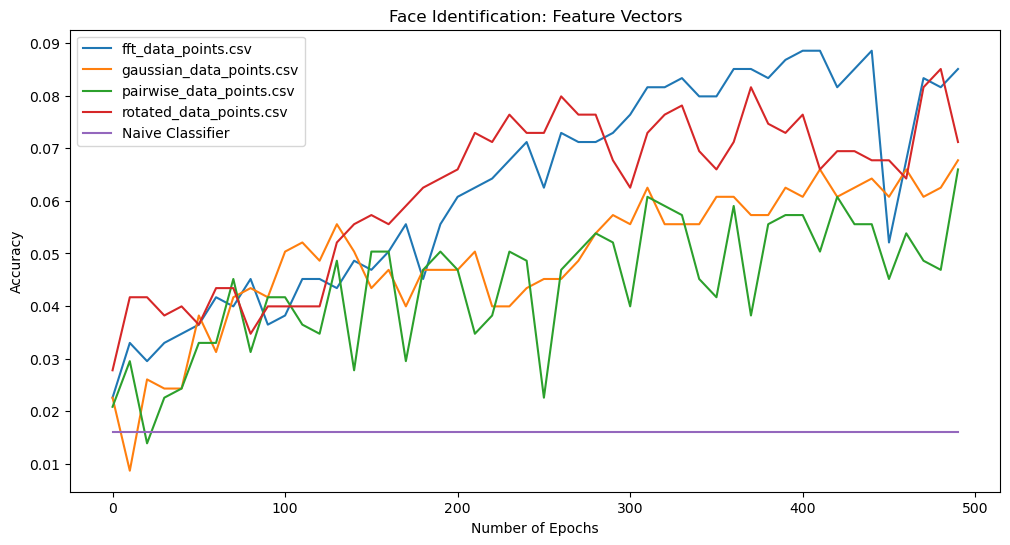

In [8]:
from bioNet import VGG16_MetricNet


def train_vgg16_model(data, n_epochs=200, batch_size=500, learning_rate=0.001):
    """
    Trains a VGG16-like model on the provided data.

    Parameters:
        data (pd.DataFrame): Input data with features and 'label' column.
        model_class (class): Class for the model to instantiate (e.g., VGG16_MetricNet).
        n_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model: Trained model.
        val_accuracy_list (list): List of validation accuracies per epoch.
    """
    X = data.drop(columns=['label']).to_numpy()
    y = data['label'].to_numpy()

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    input_size = X_train.shape[1]
    num_classes = len(label_encoder.classes_)

    model = VGG16_MetricNet(input_shape=input_size, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    val_accuracy_list = []

    for epoch in range(n_epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            Xbatch = X_train_tensor[i:i + batch_size]
            ybatch = y_train_tensor[i:i + batch_size]

            y_pred = model(Xbatch)
            loss = criterion(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            _, val_pred = torch.max(val_outputs, 1)
            val_accuracy = accuracy_score(y_test_tensor.numpy(), val_pred.numpy())
            

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")
            val_accuracy_list.append(val_accuracy)

    return model, val_accuracy_list


directory = "../Pre-processing/dataset/anchor_points_dataset/face_recognition/"
plt.figure(figsize=(12, 6))
plt.title('Face Identification: Feature Vectors')
epochs = 500
for file in os.listdir(directory):
    path = os.path.join(directory, file)
    df = pd.read_csv(path)
    _, acc = train_vgg16_model(df, n_epochs=epochs)
    plt.plot(np.arange(epochs, step=10), acc, label=file)

plt.plot(np.arange(epochs, step=10), np.zeros(int(epochs/10)) + 1/num_classes, label='Naive Classifier')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()


## Face Validation

Files already downloaded and verified
Files already downloaded and verified
2200
Epoch 1/100, Loss: 409.3090, Train Accuracy: 0.5145, Test Accuracy: 0.5070
Epoch 2/100, Loss: 399.3993, Train Accuracy: 0.5223, Test Accuracy: 0.5280
Epoch 3/100, Loss: 398.9706, Train Accuracy: 0.5364, Test Accuracy: 0.5190
Epoch 4/100, Loss: 397.5614, Train Accuracy: 0.5418, Test Accuracy: 0.5220
Epoch 5/100, Loss: 398.5548, Train Accuracy: 0.5305, Test Accuracy: 0.5130
Epoch 6/100, Loss: 394.0956, Train Accuracy: 0.5595, Test Accuracy: 0.5190
Epoch 7/100, Loss: 390.9196, Train Accuracy: 0.5527, Test Accuracy: 0.5190
Epoch 8/100, Loss: 390.4531, Train Accuracy: 0.5650, Test Accuracy: 0.5010
Epoch 9/100, Loss: 383.7955, Train Accuracy: 0.5709, Test Accuracy: 0.5260
Epoch 10/100, Loss: 378.9792, Train Accuracy: 0.6027, Test Accuracy: 0.5520
Epoch 11/100, Loss: 380.3765, Train Accuracy: 0.6059, Test Accuracy: 0.5290
Epoch 12/100, Loss: 373.4992, Train Accuracy: 0.6005, Test Accuracy: 0.5410
Epoch 13/100, Lo

ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

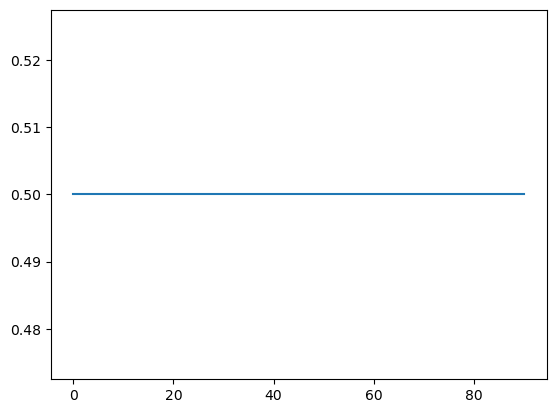

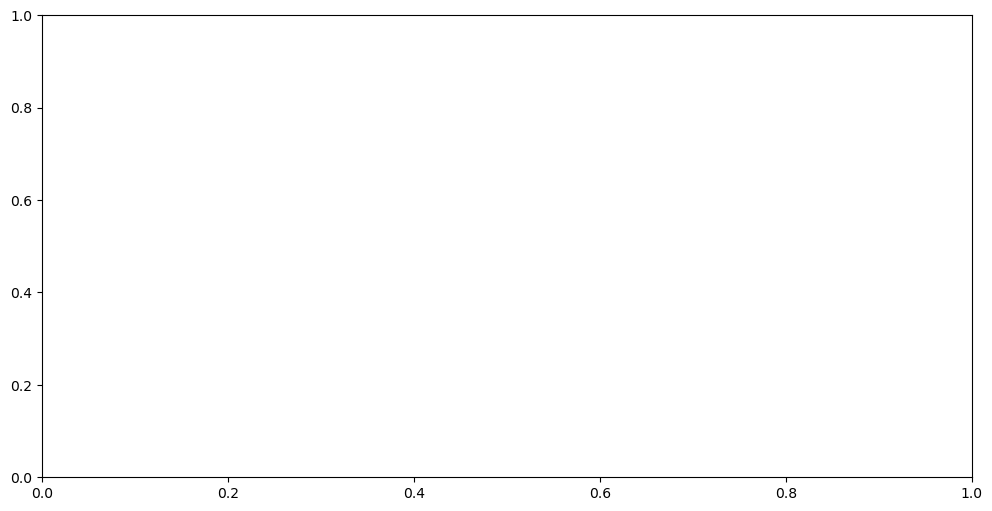

In [ ]:


mu_m = torch.tensor([0]).to(device) # Matching
mu_n = torch.tensor([40]).to(device) # Non-matching

sigma = torch.tensor([[1.0]]).to(device)
p = torch.tensor([1]).to(device)

batch_size = 16
learning_rate = 1e-3

model = BioNet().to(device=device)
criterion = BioNetLoss(p, mu_n, mu_m, sigma)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

transform = transforms.Compose([
    transforms.Resize((299, 299)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor()])

lfw_pairs_dataset_train = LFWPairs(
    root="./data/train",  
    split="train",  
    transform=transform,
    download=True
)
lfw_pairs_dataset_test = LFWPairs(
    root="./data/test",  
    split="test",  
    transform=transform,
    download=True
)

print(len(lfw_pairs_dataset_train))

train_loader = DataLoader(lfw_pairs_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(lfw_pairs_dataset_test, batch_size=batch_size, shuffle=True)

epochs = 100
val_accuracy_list = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    all_predictions = []
    all_labels = []

    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        
        # Forward pass
        distances = model(img1, img2 )
        # Compute loss
        loss = criterion(distances, labels.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        predictions = (distances < criterion.threshold()).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    all_predictions = [int(x) for sublist in all_predictions for x in sublist]
    accuracy_train = accuracy_score(all_labels, all_predictions)


    all_predictions = []
    all_labels = []
    all_distance = []
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            distances = model(img1, img2)
            
            predictions = (distances < criterion.threshold()).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy

    all_predictions = [int(x) for sublist in all_predictions for x in sublist]


    accuracy_test = accuracy_score(all_labels, all_predictions)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")
    val_accuracy_list.append(accuracy_test)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(100), val_accuracy_list, label='Neural Network')
plt.title('Face Validation: Images')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show

Epoch 10/500, Loss: 398.9675, Test Accuracy: 0.5288
Epoch 20/500, Loss: 398.3076, Test Accuracy: 0.5136
Epoch 30/500, Loss: 397.5611, Test Accuracy: 0.4924
Epoch 40/500, Loss: 397.1477, Test Accuracy: 0.5015
Epoch 50/500, Loss: 396.7049, Test Accuracy: 0.5030
Epoch 60/500, Loss: 396.3860, Test Accuracy: 0.5106
Epoch 70/500, Loss: 396.1309, Test Accuracy: 0.5091
Epoch 80/500, Loss: 395.8999, Test Accuracy: 0.5121
Epoch 90/500, Loss: 395.7054, Test Accuracy: 0.5136
Epoch 100/500, Loss: 395.5299, Test Accuracy: 0.5091
Epoch 110/500, Loss: 395.4004, Test Accuracy: 0.5136
Epoch 120/500, Loss: 395.2278, Test Accuracy: 0.5121
Epoch 130/500, Loss: 395.1103, Test Accuracy: 0.5091
Epoch 140/500, Loss: 394.9961, Test Accuracy: 0.5091
Epoch 150/500, Loss: 394.8797, Test Accuracy: 0.5076
Epoch 160/500, Loss: 394.8515, Test Accuracy: 0.5167
Epoch 170/500, Loss: 394.6817, Test Accuracy: 0.5106
Epoch 180/500, Loss: 394.7178, Test Accuracy: 0.5152
Epoch 190/500, Loss: 394.4914, Test Accuracy: 0.5106
Ep

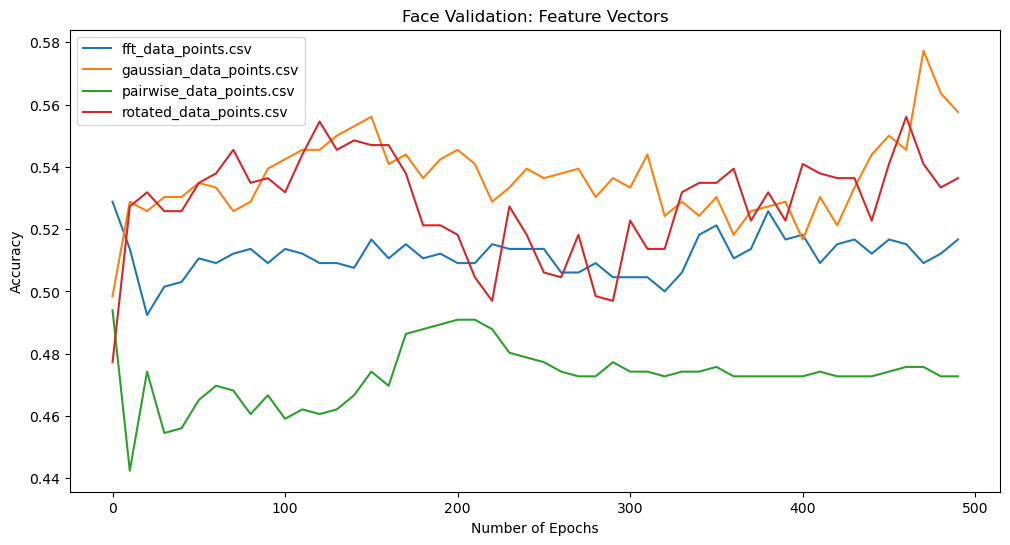

In [7]:

from bioNet import VGG16_MetricNet

def train_metricnet_model(data, n_epochs=10000, batch_size=16, learning_rate=1e-3):
    """
    Trains a MetricNet model on the provided data.

    Parameters:
        data (pd.DataFrame): Input data with features and 'label' column.
        n_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model: Trained model.
        val_accuracy_list (list): List of validation accuracies per epoch.
    """
    X = data.drop(columns=['label']).to_numpy()
    y = data['label'].to_numpy()

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    input_size = X_train.shape[1]

    mu_m = torch.tensor([0]).to(device)  # Matching
    mu_n = torch.tensor([40]).to(device)  # Non-matching
    sigma = torch.tensor([[1.0]]).to(device)
    p = torch.tensor([1]).to(device)

    model = VGG16_MetricNet(input_size).to(device)
    criterion = BioNetLoss(p, mu_n, mu_m, sigma)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    val_accuracy_list = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            Xbatch = X_train_tensor[i:i + batch_size]
            ybatch = y_train_tensor[i:i + batch_size]

            y_pred = model(Xbatch)
            loss = criterion(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                Xbatch = X_test_tensor[i:i + batch_size]
                labels = y_test_tensor[i:i + batch_size]
                distances = model(Xbatch)

                predictions = (distances < criterion.threshold()).float()

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        all_predictions = [int(x) for sublist in all_predictions for x in sublist]
        accuracy_test = accuracy_score(all_labels, all_predictions)
        

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss / (len(X_train) / batch_size):.4f}, Test Accuracy: {accuracy_test:.4f}")
            val_accuracy_list.append(accuracy_test)

    return model, val_accuracy_list

directory = "../Pre-processing/dataset/anchor_points_dataset/face_validation/"
plt.figure(figsize=(12, 6))
plt.title('Face Validation: Feature Vectors')
epochs = 500
for file in os.listdir(directory):
    path = os.path.join(directory, file)
    df = pd.read_csv(path)
    _, acc = train_metricnet_model(df, n_epochs=epochs)
    plt.plot(np.arange(epochs, step=10), acc, label=file)
plt.plot(np.arange(epochs, step=10), np.zeros(int(epochs/10)) + 1/2, label='Naive Classifier')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()